This tutorial shows how the STiMetaD class can be used for kinetics inference through the Short-Time Infrequent Metadynamics method. When initiating the class, one can set the minimal number of samples used for the inference. The default value is 5.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from STiMetaD import STiMetaD as STM
import warnings
warnings.filterwarnings('ignore')

estimator = STM(minSampleSize = 5)

We use data of Metadynamics simulations of alanine dipeptide, biasing the suboptimal $\psi$ angle as collective variable at different deposition rates.
Each data csv file contains three columns: the simulation time, the acceleration factor and the rescaled time.

All functions of the STiMetaD class require a numpy array of rescaled first-passage times. Here, we provide it with the appropriate column of the data csv file ("predicted"). The STiMetaD class provides estimations for the mean first-passage time (MFPT), the kinetic rate, and $t^*$. Below, we obtain estimations for simulations with a bias pace of 20 ps, in units of $\mu s$ or $\mu s ^ {-1}$.

In [24]:
data = pd.read_csv("alanineDipeptide/psi20.csv")
samples = np.array(data.predicted)
print(f"MFPT: {estimator.estimateMFPT(samples = samples) / 1e6}, "\
      f"k: {estimator.estimateRate(samples = samples) * 1e6}, "\
      f"t*: {estimator.estimateTstar(samples = samples) / 1e6}")

MFPT: 5.0546241896400215, k: 0.19783864486891112, t*: 0.1514917126


We can choose other values for the minimal numbers of samples,
by setting the minSampleSize parameter.

In [25]:
print(f"MFPT (minimum 5 samples): {estimator.estimateMFPT(samples = samples) / 1e6}, "\
      f"MFPT (minimum 50 samples): {estimator.estimateMFPT(samples = samples, minSampleSize = 50) / 1e6}")

MFPT (minimum 5 samples): 5.0546241896400215, MFPT (minimum 50 samples): 8.398149074709304


We can also obtain a pandas dataframe with estimations of the kinetic rates for different choices of $t^*$. It also gives $R^2$ for each estimation.

In [26]:
print(estimator.obtainEstimationsDataFrame(samples = samples, minSampleSize = 5)[:10])

          Tstar    prediction        R2
0  23289.943500  1.391923e-07  0.805184
1  33849.311881  1.431131e-07  0.885909
2  34869.917104  1.525084e-07  0.903221
3  41944.413164  1.572324e-07  0.929170
4  45725.439924  1.622596e-07  0.941932
5  49134.368885  1.674673e-07  0.947387
6  54918.959304  1.710456e-07  0.955537
7  62037.590678  1.726921e-07  0.964751
8  62251.465158  1.766459e-07  0.964608
9  68237.711000  1.794084e-07  0.967944


Lastly, the class can also give the standard iMetaD estimation, and the p-value of a Kolmogorov–Smirnov test. The number of samples from the fitted exponential distribution is adjustable.

In [27]:
print(f"MFPT (iMetaD): {estimator.iMetaDMFPT(samples = samples) / 1e6}, "\
      f"k (iMetaD): {estimator.iMetaDrate(samples = samples) * 1e6}, "\
      f"MFPT, p-value: {estimator.iMetaDMFPT(samples = samples, KStest = True, fitSamples = 1000000)}, "\
      f"k, p-value: {estimator.iMetaDrate(samples = samples, KStest = True, fitSamples = 1000000)}")

MFPT (iMetaD): 33.19179697649364, k (iMetaD): 0.03012792590615681, MFPT, p-value: (33191796.97649364, 2.2321248724280075e-26), k, p-value: (3.012792590615681e-08, 2.6150743132424274e-26)


Below, we reproduce Figures 2, 3(a,b), and 4(b) to demontrate the use of the class.

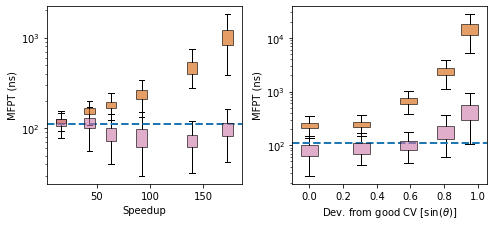

In [28]:
unbiased = 110372.643984 # Unbiased MFPT in ps
Nsamples = 200
Nbatches = 1000
np.random.seed(25198)

fig, axs = plt.subplots(1, 2, figsize=(7., 3.25))

paces = [1, 2, 5, 10, 20, 100]
angles = np.array([0, 18, 36, 54, 72])

for pace in paces:
    
    fullData = pd.read_csv(f"WolfeQuapp/0_{pace}.csv")
    iMetaD = []
    STiMetaD = []
    speedup = []
    
    for i in range(Nbatches):
        
        data = fullData.sample(Nsamples)
        samples = np.array(data.predicted)
        iMetaD.append(estimator.iMetaDMFPT(samples = samples) / 1e3)
        STiMetaD.append(estimator.estimateMFPT(samples = samples) / 1e3)
        speedup.append(unbiased / data.time.mean())
        
    axs[0].boxplot(iMetaD, positions = [np.mean(speedup)], widths = 10, showfliers = False, manage_ticks = False,
                   boxprops = dict(alpha = 0.6, facecolor = '#D55E00'), medianprops = {"linestyle": "none"}, patch_artist = True)
    axs[0].boxplot(STiMetaD, positions = [np.mean(speedup)], widths = 10, showfliers = False, manage_ticks = False,
                   boxprops = dict(alpha = 0.6, facecolor = '#CC79A7'), medianprops = {"linestyle": "none"}, patch_artist = True)

axs[0].set_xlabel("Speedup")
axs[0].set_ylabel("MFPT (ns)")

for angle in angles:
    
    fullData = pd.read_csv(f"WolfeQuapp/{angle}_5.csv")
    iMetaD = []
    STiMetaD = []
    
    for i in range(Nbatches):
        
        data = fullData.sample(Nsamples)
        samples = np.array(data.predicted)
        iMetaD.append(estimator.iMetaDMFPT(samples = samples) / 1e3)
        STiMetaD.append(estimator.estimateMFPT(samples = samples) / 1e3)
        
    axs[1].boxplot(iMetaD, positions = [np.sin(angle * np.pi / 180)], widths = 0.1, showfliers = False, manage_ticks = False,
                   boxprops = dict(alpha = 0.6, facecolor = '#D55E00'), medianprops = {"linestyle": "none"}, patch_artist = True)
    axs[1].boxplot(STiMetaD, positions = [np.sin(angle * np.pi / 180)], widths = 0.1, showfliers = False, manage_ticks = False,
                   boxprops = dict(alpha = 0.6, facecolor = '#CC79A7'), medianprops = {"linestyle": "none"}, patch_artist = True)        

for i in range(2):
    axs[i].set_xlim(*axs[i].get_xlim())
    axs[i].plot(axs[i].get_xlim(), [unbiased / 1e3, unbiased / 1e3], linestyle = "dashed", linewidth = 2)
    axs[i].set_yscale("log")

axs[1].set_xlabel(r"Dev. from good CV [sin($\theta$)]")
axs[1].set_ylabel("MFPT (ns)")

fig.tight_layout()

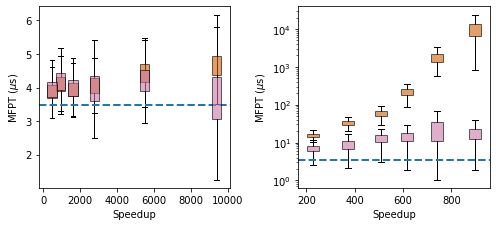

In [29]:
unbiased = 3494120 # Unbiased MFPT in ps
np.random.seed(172198)

fig, axs = plt.subplots(1, 2, figsize=(7., 3.25))

CVs = ["phi", "psi"]
paces = [1, 2, 5, 10, 20, 50]
widths = [500, 50]
for j in range(2):
    
    for pace in paces:
        
        fullData = pd.read_csv(f"alanineDipeptide/{CVs[j]}{pace}.csv")
        iMetaD = []
        STiMetaD = []
        speedup = []
        
        for i in range(Nbatches):
            
            data = fullData.sample(Nsamples)
            samples = np.array(data.predicted)
            iMetaD.append(estimator.iMetaDMFPT(samples = samples) / 1e6)
            STiMetaD.append(estimator.estimateMFPT(samples = samples) / 1e6)
            speedup.append(unbiased / data.time.mean())
            
        axs[j].boxplot(iMetaD, positions = [np.mean(speedup)], widths = widths[j], showfliers = False, manage_ticks = False,
                       boxprops = dict(alpha = 0.6, facecolor = '#D55E00'), medianprops = {"linestyle": "none"}, patch_artist = True)
        axs[j].boxplot(STiMetaD, positions = [np.mean(speedup)], widths = widths[j], showfliers = False, manage_ticks = False,
                       boxprops = dict(alpha = 0.6, facecolor = '#CC79A7'), medianprops = {"linestyle": "none"}, patch_artist = True)
            
    axs[j].set_xlabel("Speedup")
    axs[j].set_ylabel(r"MFPT ($\mu$s)")

for i in range(2):
    axs[i].set_xlim(*axs[i].get_xlim())
    axs[i].plot(axs[i].get_xlim(), [unbiased / 1e6, unbiased / 1e6], linestyle = "dashed", linewidth = 2)
    
axs[1].set_yscale("log")

fig.tight_layout()

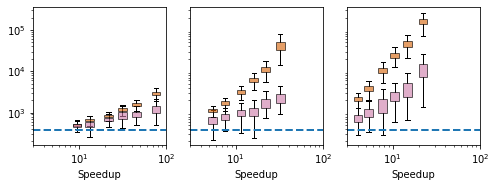

In [30]:
unbiased = 3.76e5 # Unbiased MFPT in ps
np.random.seed(250996)
width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

fig, axs = plt.subplots(1, 3, figsize=(7., 2.7))

paces = [20, 50, 100, 200, 500, 1000]
CVs = ["HLDA", "Rg", "RMSD"]

for j in range(3):

    for pace in paces:
        
        fullData = pd.read_csv(f"chignolin/{CVs[j]}{pace}.csv")
        iMetaD = []
        STiMetaD = []
        speedup = []
        
        for i in range(Nbatches):
            
            data = fullData.sample(Nsamples)
            samples = np.array(data.predicted)
            iMetaD.append(estimator.iMetaDMFPT(samples = samples) / 1e3)
            STiMetaD.append(estimator.estimateMFPT(samples = samples) / 1e3)
            speedup.append(unbiased / data.time.mean())
            
        axs[j].boxplot(iMetaD, positions = [np.mean(speedup)], widths = width(np.mean(speedup), 0.1), showfliers = False, manage_ticks = False,
                       boxprops = dict(alpha = 0.6, facecolor = '#D55E00'), medianprops = {"linestyle": "none"}, patch_artist = True)
        axs[j].boxplot(STiMetaD, positions = [np.mean(speedup)], widths = width(np.mean(speedup), 0.1), showfliers = False, manage_ticks = False,
                       boxprops = dict(alpha = 0.6, facecolor = '#CC79A7'), medianprops = {"linestyle": "none"}, patch_artist = True)
    
    axs[j].plot([3, 100], [unbiased / 1e3, unbiased / 1e3], linestyle = "dashed", linewidth = 2)
    axs[j].set_xlabel("Speedup")
    axs[j].set_xscale("log")
    axs[j].set_yscale("log")
    axs[j].set_xlim(3, 100)

for i in range(1,3):
    
    axs[i].set_yticks([])
    axs[i].set_yticks([])
    
for i in range(3):
    
    axs[i].set_ylim(min([axs[j].get_ylim()[0] for j in range(3)]), max([axs[j].get_ylim()[1] for j in range(3)]))

fig.tight_layout()